# Adaptive PDE discretizations on Cartesian grids
## Volume : Divergence form PDEs
## Part : Primal-Dual optimization
## Chapter : Vector unbalanced optimal transport based on the Beckman formula

$
\newcommand\bR{\mathbb{R}}
\def\vp{\varphi}
\def\ve{\epsilon}
\def\<{\langle} \def\>{\rangle}
\def\diff{\mathrm{d}}
\def\cF{\mathcal{F}}
\DeclareMathOperator*\argmin{argmin}
\DeclareMathOperator\prox{prox}
\DeclareMathOperator\pinv{pinv}
\DeclareMathOperator\span{span}
\DeclareMathOperator\step{step}
\DeclareMathOperator\diver{div}
$

We implement a relaxed form of matrix optimal transport, based on the Bellman formulation of the $1$-Wasserstein distance, with a squared penalty term for the constraint.

### Beckman minimal flow formula

The 1-Wasserstein optimal transport distance, between two densities $\mu$ and $\nu$ expressed using the *Beckmann minimal flow formula* as
$$
    W^1(\mu,\nu) = \inf_\sigma \{\int |\sigma|; \diver \sigma = \mu-\nu\}.
$$
**Boundary condition.** We assume that $\sigma \cdot n = 0$, i.e. no mass flows inside or outside the domain. 

### Relaxation of the transport constraint

A relaxation of the *Beckmann minimal flow formula* can be defined for any (large) $\lambda>0$ and any exponent $p\in [1,\infty[$ as 
$$
    W^1_{\lambda,p}(\mu,\nu) := \inf_\sigma \int |\sigma| + \frac \lambda p \int |\diver \sigma +\nu-\mu |^p.
$$
Such a relaxation is necessary if the masses of $\mu$ and $\nu$ are distinct.

The choice $p=1$ is easily the most natural when $\mu$ and $\nu$ are densities. 
However, in the intended application, $\mu$ and $\nu$ are seismograms, which means that the squares $\mu^2$ and $\nu^2$ can be regarded as energy densities. This, together with disappointing experiments in the $p=1$ case, leads us to focus on $p=2$ in this notebook.

In the following, we denote $\xi := \nu - \mu$.

### Vector extension
The Beckmann formula admits a straightforward generalizations to vector valued measures $\mu$ and $\nu$, and so do their unbalanced extensions (which are typically preferable in this context since the mass balance equation is usually not satisfied).

In order to avoid transporting a measure onto itself, it is natural to assume that $\mu$ and $\nu$ are valued within a cone of vectors, such as the non-negative vectors $\bR_+^d \subset \bR^d$, or the non-negative symmetric matrices $S_d^+ \subset S_d$.

### The Chambolle-Pock primal-dual optimization algorithm

This algorithm addresses saddle point problems of the form
$$
    \inf_{x\in X} \sup_{y\in Y} L(x,y) := \<K x,y\> + f(x) - g^*(y),
$$
where $X,Y$ are Hilbert spaces, where $K$ is a linear operator, and $f$ and $g$ are convex functions, subject to mild assumptions.

The saddle point problem defined by the *Lagrangian* $L(x,y)$ is equivalent to the 'primal' minimization of $E$, and 'dual' maximization of $E^*$, where
$$
    \inf_{x\in X} E(x) := f(x)+g(K x)
$$
and 
$$
    \sup_{y\in Y} E^*(y) := - (g^*(y)+f^*(-K^\top y)).
$$
One always has $E(x) \geq E^*(y)$, with equality when a $(x,y)$ is a saddle point.

The algorithm, which simultaneously minimizes $E$ and maximizes $E^*$, reads in its basic version
$$
    x^{n+1} = \prox_{\tau_1 f} (x^n - \tau_1 K^\top y^n),\quad
    \overline x^{n+1} = 2 x^{n+1} - x^n,\quad
    y^{n+1} = \prox_{\tau_2 g^*}(y^n + \tau_2 K \overline x^{n+1}).
$$
Running this algorithm requires an implementation of 
- the linear operators $K$ and $K^\top$, and time steps $\tau_1>0$, $\tau_2>0$, such that $\tau_1\tau_2 < \|K\|^2$.
- the proximal operators $\prox_{\tau f}$ and $\prox_{\tau g}$
- optionally, the functionals $f$, $f^*$, $g$ and $g^*$, which allows using the primal dual gap as a stopping criterion.

### Primal-dual formulation, explicit

We consider the *Lagrangian*
$$
    L(\vp,\sigma) := \int \<\nabla \vp,\sigma\> + (\frac 1 {2\lambda} \vp^2 - \xi \vp) - |\sigma|.
$$
In other words, with the $x=\vp \in L^2$, $y=\sigma\in (L^2)^d$, and 
$$
    K = \nabla,\quad f(\vp):=\int_\Omega \frac 1 {2\lambda} \vp^2-\vp \xi,\quad g^*(\sigma) = \int_\Omega |\sigma|.
$$
Note that the numerical scheme implementing $K$ is bounded in terms of the grid scale, even though the linear operator $K$ itself is unbounded in the continuous domain. The implementation of this approach does not require solving any optimization problem, hence it is referred to as 'explicit'.


<!---
\begin{align*}
    L(\vp,\sigma) 
    &:= \int \<\nabla \vp,\sigma\> + (\frac 1 {2\lambda} \vp^2 - \xi \vp) - |\sigma|,\\
    &:= - \int |\sigma| + \<\diver\sigma+\xi,\vp\> - \frac 1 {2\lambda} \vp^2,
\end{align*}
where the equality follows from the adjointness of gradient and negative divergence.
--->

The corresponding *primal energy*,  is obtained as 
$$
    E(\vp) := \sup_\sigma L(\sigma,\vp) = \int \frac 1 {2\lambda} \vp^2 - \vp \xi + \chi_{|\nabla \vp|\leq 1},
$$
where the characteristic function $\chi_{|\nabla \vp|\leq 1}$ vanishes if $|\nabla \vp|\leq 1$, and equals $\infty$ otherwise.

Noting that, by the adjointness of gradient and negative divergence,
$$
L(\vp,\sigma) = - \int |\sigma| + \<\diver\sigma+\xi,\vp\> - \frac 1 {2\lambda} \vp^2,
$$
we obtain the *dual energy* as 
$$
    E^*(\sigma) := \inf_\vp L(\sigma,\vp) = -\int |\sigma| + \frac \lambda 2  |\diver \sigma +\xi |^2,
$$
thus $E^*$ is (the opposite of) the energy defining the problem of interest.

<!---
The problem that we would like to address is thus, 
$$
    \inf_\vp E(\sigma) = \inf_\vp \sup_\sigma L(\sigma,\vp) = \sup_\sigma E^*(\vp),
$$
by the usual duality argument, which we do not attempt to justify here.

We rely on the Chambolle-Pock primal dual optimization algorithm. Note that $\frac 1 {2\lambda} \vp^2$ is a strongly convex term, which allows the usage of an accelerated variant. Alternative methods could be used as well, such as the forward backward algorithm.

**Brouillon**
For the problem of interest,
$$
    K = \nabla,\quad f(\vp):=\int_\Omega \frac 1 {2\lambda} \vp^2-\vp \xi,\quad g^*(\sigma) = \int_\Omega |\sigma|.
$$
We present below some implementations of $K$, $K^\top$, $\prox_f$, $\prox_{g^*}$, as needed to run the optimization algorithm.

$$
    \inf_\vp \sup_\sigma \<K \sigma,\vp\> + f(\sigma) - g^*(\vp),
$$
where $K$ is a linear operator, and $f$ and $g$ are convex functions.
--->

### Primal dual formulation, implicit

We can define $K=K^\top=\mathrm{Id}$, and let $x=\sigma$, $y=\eta$, and 
$$
    f(\sigma):= \int_\Omega |\sigma|,\quad g(\sigma) := \int \frac \lambda 2  |\diver \sigma +\xi |^2.
$$
The computation of $g^*$ and $\prox_g$ is discussed below. The approach allows using larger proximal time steps, but requires the inversion of a linear system (which may be accelerated using a fast Fourier transform), hence it is referred to as 'implicit'.

### Numerical implementation, and discussion of efficiency

We assume that $\mu$ and $\nu$ are supported over a rectangular domain, and use staggered finite differences, similarly to the mincut problem. Reflected boundary conditions on $\sigma$ ensure that no mass flows outside the domain. 

The numerical implementations presented below are not state of the art, and are likely not suitable for realistic applications. They should only be regarded as experimentation and tutorial on the topic of primal dual optimization. More precisely, on large test cases:
- The implicit discretization suffers from the choice of linear solver. An approach based on the FFT would be applicable and much more efficient.
- The explicit discretization (cpu or gpu) suffers from the excessive number of time steps, up to hundreds of thousands, which increases as the grid scale decreases and makes numerical cost excessive. The gpu implementation also suffers from the limited accuracy of `float32` scalars. 

<!---
### $H^{-1}$ variant
The following quantity
$$
    H^{-1}_\lambda(\mu,\nu)^2 := \inf_\sigma \int |\sigma|^2 + \lambda \int |\nabla \cdot \sigma -( \mu-\nu) |^2,
$$
is equivalent to the Sobolev $H^{-1}$ norm of $\mu-\nu$. Its computation only requires solving a single linear system, discretizing a Poisson equation. 
--->
### References

- F. Santambrogio, (2015). *Optimal transport for applied mathematicians*. Birkäuser, NY, 55(58-63), 94.



[**Summary**](Summary.ipynb) of volume Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Implementation of the operators](#1.-Implementation-of-the-operators)
    * [1.1 Proximal operator of the quadratic term in the explicit formulation](#1.1-Proximal-operator-of-the-quadratic-term-in-the-explicit-formulation)
    * [1.2 Proximal operator of the Euclidean norm](#1.2-Proximal-operator-of-the-Euclidean-norm)
    * [1.3 Gradient](#1.3-Gradient)
    * [1.4 Implicit formulation](#1.4-Implicit-formulation)
  * [2. One dimensional transport](#2.-One-dimensional-transport)
    * [2.1 Running the primal-dual optimizers](#2.1-Running-the-primal-dual-optimizers)
    * [2.2 Comparing with exact solutions](#2.2-Comparing-with-exact-solutions)
    * [2.3 Vector data](#2.3-Vector-data)
  * [3. Two dimensions](#3.-Two-dimensions)
    * [3.1 From a Dirac mass to another](#3.1-From-a-Dirac-mass-to-another)
    * [3.2 Oscillating signals and lift](#3.2-Oscillating-signals-and-lift)
    * [3.3 A loss function between seismograms](#3.3-A-loss-function-between-seismograms)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,'../../AdaptiveGridDiscretizations')

In [2]:
from agd import AutomaticDifferentiation as ad
from agd import LinearParallel as lp
from agd.ODE.proximal import chambolle_pock
norm = ad.Optimization.norm
from agd import Plotting
from agd import Metrics
from agd import FiniteDifferences as fd

In [3]:
from agd.Eikonal.HFM_CUDA.MinCut import stag_grids
from agd.ExportedCode.Notebooks_Div.Prox_MinCut import drop, grad_ndiv_operators

In [4]:
import numpy as np; xp=np
from matplotlib import pyplot as plt
import scipy.sparse.linalg

In [5]:
from Miscellaneous import rreload
def reload_packages():
    global chambolle_pock,BeckmanOT
    chambolle_pock,BeckmanOT = rreload.rreload((chambolle_pock,BeckmanOT),rootdir="../..")

### 0.1 Additional configuration

Uncomment the following line to use the gpu implementation (requires a cuda enabled GPU).

<!---
In addition to the CPU implementation described below, a (reasonnably) optimized GPU implementation of the explicit formulation is provided.

The GPU implementation offers a 300x speedup, for sufficiently large instances, and is also (reasonnably) simple. It may be used as a starting point for GPU implementations of the Chambolle-Pock optimization algorithm in other settings.
--->

In [6]:
#import cupy as xp; from agd.Eikonal.HFM_CUDA import BeckmanOT 

The CPU and GPU implementations are meant to be consistent up to machine precision. The following method checks this property.

In [7]:
def compare_cpu_gpu(data_cpu,maxiter=20,data_gpu=None,**kwargs):
    if xp is np: return # No GPU available
    res_cpu,data = solve1_ot(*data_cpu,maxiter=maxiter,E_rtol=0,**kwargs) # Run on the cpu

    # Run on the gpu
    (λ,ξ,dx) = data_cpu if data_gpu is None else data_gpu 
    res_gpu = BeckmanOT.solve_ot(λ,xp.asarray(ξ,dtype=np.float32),dx,maxiter=maxiter,E_rtol=0,stop_period=1,**kwargs)

    # Compare the results
    ops,tmp = res_cpu['ops'],res_cpu['tmp']
    E_primal,E_dual = ops['E_primal'],ops['E_dual']
    def norminf(a): return np.max(np.abs(a))
    print("ϕ max error : ",norminf(res_gpu["ϕ"].get()-res_cpu['x']))
    print("σ max error : ",norminf(res_gpu["σ"].get()-res_cpu['y']))
    print(f"primal value. GPU={res_gpu['primal_values'][-1]}, CPU={E_primal(tmp['x_'])}")
    print(f"dual value. GPU={res_gpu['dual_values'][-1]}, CPU={E_dual(tmp['yold'])}")

    tols={'rtol':1e-5,'atol':1e-5}; 
    assert np.allclose(res_gpu['dual_values'][-1],E_dual(tmp['yold']),**tols)
    assert np.allclose(res_gpu['primal_values'][-1],E_primal(tmp["x_"]),**tols)
    assert np.allclose(res_gpu["ϕ"].get(),res_cpu['x'],**tols)
    assert np.allclose(res_gpu["σ"].get(),res_cpu['y'],**tols)

## 1. Implementation of the operators

Two of the proximal operators that we implement are related to quadratic functions. For generality, consider a generic  inhomogeneous quadratic function $g$ defined as 
$$
    g(z) = \tfrac 1 2 z^\top A z + b^\top z + c,
$$
where $A$ is positive semi-definite, $b$ is a vector, and $c$ is a constant.
Then one easily checks that
$$
        \prox_{\tau g}(z) = (1+\tau A)^{-1} (z-\tau b), \quad g^*(z) = \frac 1 2 (z-b)(\epsilon+A)^{-1}(z-b) - c
$$
where we introduced a relaxation parameter $\ve\geq 0$. Note that the exact Legendre-Fenchel dual is obtained when $\ve=0$, but is finitely valued only if $A$ is symmetric positive definite. If this condition is not satisfied, then we use $\ve >0$ numerically. 


### 1.1 Proximal operator of the quadratic term in the explicit formulation

Observe that 
$$
    f(\vp):=\int_\Omega \frac 1 {2\lambda} \vp^2-\vp \xi,
$$
is a separable function of the pointwise values of $\vp$, defined pointwise by a quadratic expression.
Therefore we can compute pointwise the related proximal operator and Legendre-Fenchel dual, using the previous formulas.

<!---
We recognize a quadratic function, Consider the quadratic function 
$$
    f_0(\vp) := \frac 1 {2\lambda} \vp^2 - \xi \vp.
$$
The proximal operator of an isotropic quadratic function admits an explicit expression, which is easily computed: the quantity
$$
    \eta \mapsto \frac 1 2 (\eta-\vp)^2 + \tau \Big(\frac 1 {2\lambda} \eta^2 - \xi \eta\Big)
$$
is minimized when $\eta - \vp + \tau\eta/\lambda - \tau\xi$, equivalently
$$
\prox_{\tau f}(\phi) = \eta = (1+\tau/\lambda)^{-1}(\vp+\tau \xi).
$$
Likewise, we compute the Legendre-Fenchel dual.

onsider the pointwise expression of $f$, which reads 
A similar approach is applied to the 
--->

In [8]:
def make_f(λ,ξ):
    def f(ϕ): return (ϕ**2/(2.*λ)-ξ*ϕ).sum()
    def fs(ϕ): return ((λ/2.)*(ϕ+ξ)**2).sum()
    def prox_f(ϕ,τ): return (ϕ+τ*ξ)/(1+τ/λ)
    return f,fs,prox_f

### 1.2 Proximal operator of the Euclidean norm

The function $g^*(\sigma)$ is defined as the integration over $x\in \Omega$ of the norm of $\sigma(x)$.
We choose to implement using a *metric* object for extensibility, allowing for instance the generalization
$$
    g^*(\sigma) := \int \cF_x(\sigma(x)) \diff x
$$
which involves a (Isotropic, Riemannian, Finsler, etc) metric over the domain $\Omega$. See the [notebook on the mincut problem](Prox_MinCut.ipynb) on the choice of metric in a related setting.

The function $g^*$ is separable, hence the dual function and the proximal operator can be computed pointwise.
- The Legendre-Fenchel dual to a norm $g_0^*(x) = \cF_0(x)$ is the characteristic function $g_0 = \chi_{B^*}$ of the unit ball $B$ of the dual metric $\cF^*_0(x)$ (note that norm duality is not the same as Legendre-Fenchel duality). In order to get finite result, we implement a relaxation of this characteristic function. This relaxation only affects the stopping criterion of the optimization algorithm.
- The dual proximal operator $\prox_{\tau g_0}$ is the othogonal projection onto $B^*$, and the proximal operator $\prox_{\tau g_0^*}$ can be computed using the Moreau formula.

<!---
$$
    abs(\sigma) := |\sigma|, \abs^*(\sigma):=\chi_{[-1,1]}(\sigma), \prox_
$$
--->

In [9]:
def make_gs(multichannel_depth=0,relax_norm_constraint=0.01):
    """
    Inputs : 
    - multichannel_depth : the number of additional dimensions for multichannel inputs
    - relax_norm_constraint : a small relaxation parameter used in the characteristic function approximation
    """
    def rsh(σ): return σ.reshape((-1,*σ.shape[1+multichannel_depth:])) 
    metric = Metrics.Isotropic(1.)
    prox = metric.make_prox() # Proximal operator of the norm
    proj = metric.make_proj_dual() # Projection onto the dual unit ball
    
    def gs(σ):  return metric.norm(rsh(σ)).sum()
    def g(σ): # Some (arbitrary) relaxation of the characteristic function of the ball
        violation = np.maximum(0,metric.norm(rsh(σ))-1) # How much the norm constraint is violated
        return np.sum(violation**2)/relax_norm_constraint**2 
    def prox_gs(σ,τ): return prox(rsh(σ),τ).reshape(σ.shape)
    return gs,g,prox_gs

### 1.3 Gradient

We use upwind finite differences, on a staggered grid.
In dimension $1$, the chosen scheme is second order consistent. In dimension two, it is only first order consistent.
Note that the `grad2` scheme corresponds to the `gradc` scheme in the [notebook on the mincut problem](Prox_MinCut.ipynb).

In [10]:
def grad1(ϕ,dx): return (drop(ϕ,1,axis=-1)-drop(ϕ,-1,axis=-1))[None]/dx
def grad2(ϕ,dx): return ad.array([drop(drop(ϕ, 1,axis=-2+i)-drop(ϕ,-1,-2+i),-1,-1-i)/dxi
                                  for i,dxi in enumerate(dx)])

The Chambolle-Pock primal-dual optimization algorithm requires the proximal steps sizes to obey a CFL condition, involving the squared norm of the gradient operator. The latter is classically estimated as below.

In [11]:
def norm2_grad(dx): 
    """
    Squared norm of the basic discretized gradient operator 
    (assuming one grid scale per dimension).
    """
    return 4*sum(dxi**-2 for dxi in dx)

The function `grad_ndiv_operators` then conveniently computes the negative divergence by assembling the (sparse) matrix of the gradient, via automatic differentiation, and transposing it.

### 1.4 Implicit formulation

The second primal-dual formulation of the Beckman optimal transport problem does not involve a coupling operator ($K=\mathrm{Id}$), but requires to solve a some linear systems in each iteration. It is based on the following functionals:

$$
    f(\sigma):= \int_\Omega |\sigma|,\quad g(\sigma) := \int \frac \lambda 2  |\diver \sigma +\xi |^2.
$$

In [12]:
# The coupling operator of the second implementation is the identity
def make2_K():
    """Make the identity operator"""
    def K(x): return x
    K.T=K # Identity is its own transpose
    return K

# The operator f of the second implementation is g^* from the first.
def make2_f(*args,**kwargs): return make_gs(*args,**kwargs)

Regarding $g$, we recognize a quadratic expression, as considered in the introduction of this section. We first the proximal operator and dual function in the generic case using automatic differentiation to compute the coefficients.

**Note on performance.** For the application of interest, a more efficient way to solve the linear systems considered here would be to use a fast Fourier transform. However, we do not follow this approach here for simplicity. (Multigrid methods, or suitable sparse Cholesky factorizations, would also apply.)

In [13]:
def make_quad(f,shape,τ,relax_dual=1e-3):
    """
    Sparse matrix based implementations of a convex quadratic function f,
    the Legendre-Fenchel conjugate, and the proximal operator.
    Inputs
    - f : an implementation of a (possibly inhomogeneous) quadratic f
    - shape : input shape for f
    - τ : time step for the proximal operator (frozen)
    - relax_dual : a small relaxation parameter for the computation of the dual
    """
    z_ad = ad.Sparse2.identity(shape)
    f_ad = f(z_ad) # Second order Taylor expansion of f at zero
    #ad.simplify_ad(f_ad) # counterproductive here
    A = f_ad.hessian_operator().T # Transpose for csc format
    b = f_ad.to_first().to_dense().coef # First order term
    c = f_ad.value # Constant term
    eye = scipy.sparse.eye(z_ad.size)
    iAτ = scipy.sparse.linalg.factorized(τ*A+eye) 
    iAϵ = scipy.sparse.linalg.factorized(A+relax_dual*eye)
    def f_(z): # Reimplementation using sparse matrices for efficiency
        z=z.reshape(-1) 
        return np.sum((0.5*(A*z)+b)*z)+c
    def fs(z): # Relaxed legendre-Fenchel dual
        t=z.reshape(-1)-b
        return np.sum(0.5*iAϵ(t)*t)-c
    def prox_f(z,τ2): # Proximal operator of f
        assert τ==τ2
        return iAτ(z.reshape(-1)-τ*b).reshape(z.shape)
    return f_,fs,prox_f

Now we can implement $g(\sigma) := \int \frac \lambda 2  |\diver \sigma +\xi |^2$, and deduce the related operators.

In [14]:
def div1(σ,dx):
    """Divergence of σ (no flux on boundary σ.n = 0, dual to upwind scheme)."""
    return np.concatenate((σ[...,:1],σ[...,1:]-σ[...,:-1],-σ[...,-1:]),axis=-1)[0]/dx

def appzero(arr,axis):
    """Appends a zero along an axis"""
    if axis<0: axis += arr.ndim
    return np.pad(arr, pad_width = ((0,0),)*axis+((0,1),)+((0,0),)*(arr.ndim-axis-1))
    
def div2(σ,dx):
    """Divergence of σ (no flux on boundary σ.n = 0, dual to upwind scheme)."""
    σ0,σ1 = σ
    return (appzero(np.concatenate([σ0[...,:1,:],σ0[...,1:,:]-σ0[...,:-1,:],-σ0[...,-1:,:]],axis=-2)/dx[0],-1) +
            appzero(np.concatenate([σ1[...,:,:1],σ1[...,:,1:]-σ1[...,:,:-1],-σ1[...,:,-1:]],axis=-1)/dx[1],-2) )

def g2(σ,λ,ξ,dx): 
    """Function implementing the divergence constraint"""
    div = {1:div1,2:div2}[len(dx)]
    return np.sum( (λ/2)*(div(σ,dx)+ξ)**2)


def shape_σ(ξ,dx):
    """Returns the shape of the vector field σ, in terms of the shape of the measure ξ and dimension"""
    ndim = len(dx)
    return (ndim,)+tuple(s-(i+ndim>=ξ.ndim) for i,s in enumerate(ξ.shape))

def make2_gs(λ,ξ,dx,τ,**kwargs):
    g,gs,prox_g = make_quad(lambda σ:g2(σ,λ,ξ,dx),shape_σ(ξ,dx),1./τ,**kwargs)
    def prox_gs(σ,τ2):
        assert τ==τ2
        return σ - τ*prox_g(σ/τ,1./τ) # Moreau formula for the dual prox
    return gs,g,prox_gs

Before running the experiments, let us validate some of these implementations.

In [15]:
np.random.seed(42)
#shape = (7,); corners = [[0],[1]]
shape = (4,3); corners = [[0,0],[1,1]]
λ=2
Xs,Xv,dx = stag_grids(shape,corners)
ξ = np.random.rand(*shape)
σ0 = np.random.rand(*shape_σ(ξ,dx))
ϕ0 = np.random.rand(*shape)

# Check that σx-σy = τ (grad g)(σy) if σy = prox_g(σx,τ)
τ=3
g_scheme=lambda σ:g2(σ,λ,ξ,dx)
g,gs,prox_g = make_quad(g_scheme,shape_σ(ξ,dx),τ)
σx = np.random.rand(*σ0.shape)
σy = prox_g(σx,τ)
g_ad = g_scheme(ad.Dense.identity(constant=σy))
assert np.allclose(σx-σy, τ*g_ad.coef.reshape(σx.shape))

# Check adjointness of gradient and divergence
grad_ = {1:grad1,2:grad2}[len(dx)]
div_ = {1:div1,2:div2}[len(dx)]
assert np.allclose((grad_(ϕ0,dx)*σ0).sum(),-(ϕ0*div_(σ0,dx)).sum())

## 2. One dimensional transport


### 2.1 Running the primal-dual optimizers

Let us generate a first instance.

<!---
μ=np.zeros_like(Xs)
μ[n//6]=1/dx # Dirac mass at 1/6

ν = np.zeros_like(Xs)
ν[(5*n)//6]=0.8/dx # Weighted Dirac mass at 5/6
--->

In [16]:
n=101
Xs,Xv,dx = stag_grids(n,[0,1]) # Grid for scalars, staggered grid for vectors, grid scale
Xs,Xv = Xs[0],Xv[0] # Only one coordinate in dimension one

# Two Gaussian bumps, with different masses
std_dev = 0.1; μ = np.exp(-(Xs-0.3)**2/(2*std_dev**2)); ν = 0.8*np.exp(-(Xs-0.6)**2/(2*std_dev**2))
# Alternatively, two Dirac measures with different masses, at 1/6 and 5/6
#μ=np.zeros_like(Xs); ν = np.zeros_like(Xs) μ[n//6]=1/dx; ν[(5*n)//6]=0.8/dx 

ξ = ν-μ # Difference of measures
λ = 1. # Relaxation parameter for the constraint

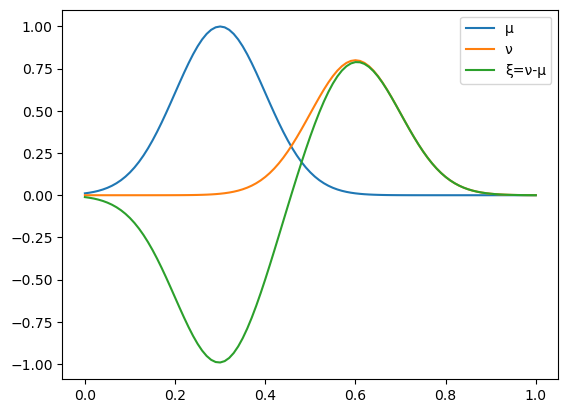

In [17]:
plt.plot(Xs,μ,label="μ")
plt.plot(Xs,ν,label="ν")
plt.plot(Xs,ξ,label="ξ=ν-μ")
plt.legend();

Now generate the various operators, using convenience functions.

In [18]:
def solve1_ot(λ,ξ,dx,τ_f=None,relax_norm_constraint=0.01,
             accelerated=False,maxiter=5000,K=None,ρ_overrelax=1.8,ϕ0=None,σ0=None,**kwargs):
    """
    Solve the Beckman optimal transport problem via explicit primal-dual optimization.
    """
    vdim = len(dx) # One grid scale per dimension. 
    if ϕ0 is None: ϕ0 = np.zeros(ξ.shape)
    
    if τ_f is None: τ_f = 5/np.sqrt(norm2_grad(dx))
    τ_gs = 1./(norm2_grad(dx)*τ_f)

    impl_f = make_f(λ,ξ)
    cvx_f = 1/λ if accelerated else 0 # Coercivity constant of f, used in accelerated variant
    impl_gs = make_gs(multichannel_depth=ξ.ndim-vdim,relax_norm_constraint=relax_norm_constraint)
    if K is None: K,_ = grad_ndiv_operators({1:grad1,2:grad2}[vdim],dx,ξ.shape)
    
    res = chambolle_pock(impl_f,impl_gs,τ_f,τ_gs,K,ϕ0,y=σ0,
                         cvx_f=cvx_f,maxiter=maxiter,ρ_overrelax=ρ_overrelax,**kwargs)
    return res,{'vdim':vdim,'τ_f':τ_f,'τ_gs':τ_gs,'cvx_f':cvx_f}

In [19]:
def solve2_ot(λ,ξ,dx,τ_f=None,relax_norm_constraint=0.01,relax_dual=1e-3,
             maxiter=5000,K=None,ρ_overrelax=1.8,**kwargs):
    """
    Solve the Beckman optimal transport problem via implicit primal-dual optimization.
    """
    vdim = len(dx) # One grid scale per dimension. 
    σ0 = np.zeros(shape_σ(ξ,dx))

    if τ_f is None: τ_f=0.01*λ
    τ_gs = 1./τ_f # Note that |K|^2 = 1 since K=Id

    K = make2_K()
    impl_f = make2_f(multichannel_depth=ξ.ndim-vdim,relax_norm_constraint=relax_norm_constraint)
    impl_gs = make2_gs(λ,ξ,dx,τ_gs,relax_dual=relax_dual)

    res = chambolle_pock(impl_f,impl_gs,τ_f,τ_gs,K,σ0,
                         maxiter=maxiter,ρ_overrelax=ρ_overrelax,**kwargs)   
    return res, {'vdim':vdim,'τ_f':τ_f,'τ_gs':τ_gs}

In [20]:
def solve3_ot(λ,ξ,dx,**kwargs): 
    """
    Solve the Beckman optimal transport problem via explicit primal-dual optimization on the GPU
    """
    res = BeckmanOT.solve_ot(λ,ξ,dx,**kwargs)
    return {key:ad.cupy_generic.cupy_get(value) for key,value in res.items()},None

The two CPU numerical solvers above are distinct approaches to the *same* optimization problem. Thus they produce identical results, up to a change of sign in the objective function, and up to the numerical accuracy.

In [21]:
res1,_ = solve1_ot(λ,ξ,dx)
res2,_ = solve2_ot(λ,ξ,dx)

print(f"Number of iterations : {res1['niter']} (explicit), {res2['niter']} (implicit)")
print(f"Explicit scheme : {-res1['primal_values'][-1]} <= W1 distance <= {-res1['dual_values'][-1]}")
print(f"Implicit scheme : {res2['dual_values'][-1]} <= W1 distance <= {res2['primal_values'][-1]}")

val1 = res1['primal_values'][-1]; val2 = res2['primal_values'][-1]
assert np.abs(val1+val2)<=2e-3*abs(val1)

# σ is the dual variable for the first approach, and the primal variable for the second approach
err_σ = np.max(np.abs(res1['y']-res2['x']))
print(f"Largest difference in solution σ between the two approaches : {err_σ}")
assert err_σ < 1e-4

Primal-dual solver completed 381 steps in 0.009198904037475586 seconds
Primal-dual solver completed 71 steps in 0.0016520023345947266 seconds
Number of iterations : 381 (explicit), 71 (implicit)
Explicit scheme : 5.143935876000981 <= W1 distance <= 5.145449398747404
Implicit scheme : 5.145514983134441 <= W1 distance <= 5.145449648021886
Largest difference in solution σ between the two approaches : 6.589223307393289e-06


We'll discuss in some explicit solutions in the next section. In the meanwhile, here is a plot.

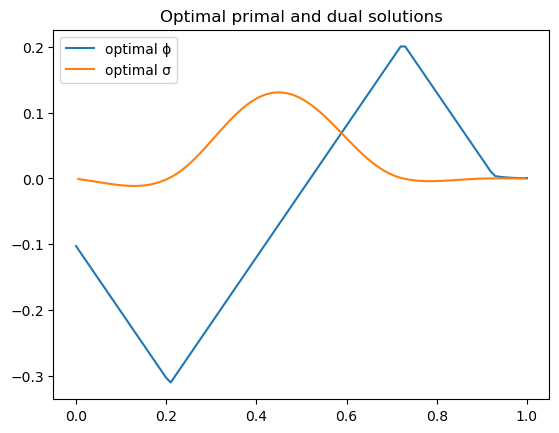

In [22]:
plt.title("Optimal primal and dual solutions")
plt.plot(Xs,res1['x'],label="optimal ϕ")
plt.plot(Xv,res1['y'][0],label="optimal σ")
plt.legend();

The energy of the solutions is very non-monotonic along the iterations of the optimization algorithm. It initially grows to large values, before decreasing.

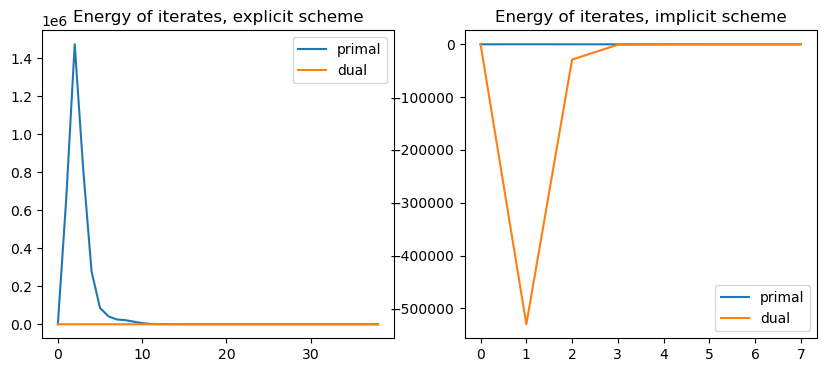

In [23]:
plt.figure(figsize=[10,4])
for i,(name,res) in enumerate((("explicit",res1),("implicit",res2))):
    plt.subplot(1,2,1+i)
    plt.title(f"Energy of iterates, {name} scheme")
    plt.plot(res['primal_values'],label="primal")
    plt.plot(res['dual_values'],label="dual")
    plt.legend()

The eikonal GPU solver is based on the explicit formulation, and produces numerical results identical to the CPU implementation up to machine precision, in the first iterations.

In [24]:
compare_cpu_gpu((λ,ξ,dx))

 Note that the GPU uses float32 scalars, which incur more numerical error that the float64 scalars used by the CPU, hence the final result may be somewhat less accurate.
 
 <!---
res3,_ = solve3_ot(λ,ξ,dx,maxiter=1,ϕ0=res1['x'],σ0=res1['y'])
print(f"Explicit scheme (gpu) : {-res3['primal_values'][-1]} <= W1 distance <= {-res3['dual_values'][-1]}")

compare_cpu_gpu((λ,ξ,dx),ϕ0=res1['x'],σ0=res1['y'])
--->

In [25]:
if xp is not np: 
    res3,_ = solve3_ot(λ,ξ,dx)
    print(f"Explicit scheme (gpu) : {-res3['primal_values'][-1]} <= W1 distance <= {-res3['dual_values'][-1]}")

**Scaling invariance**

The considered problems are invariant upon scaling $\lambda$ and the domain dimensions (equivalently, the grid scale $dx$) by the same factor. 
We illustrate this invariance numerically.

In [26]:
res1,_ = solve1_ot(λ,ξ,dx,maxiter=100)

Primal-dual solver completed 100 steps in 0.0027379989624023438 seconds


In [27]:
c0 = 10 # Simultaneous scaling of penalization, scale
res1_rescaled,_ = solve1_ot(c0*λ,ξ,c0*dx,relax_norm_constraint=0.01/np.sqrt(c0),maxiter=100)
assert np.allclose(res1_rescaled['x'],c0*res1['x']) # Same primal solution
assert np.allclose(res1_rescaled['y'],c0*res1['y']) # Same dual solution
assert res1_rescaled['niter'] == res1['niter']
assert np.allclose(res1_rescaled['primal_values'],c0*res1['primal_values']) # Same primal values
assert np.allclose(res1_rescaled['dual_values'],c0*res1['dual_values']) # Same dual values

Primal-dual solver completed 100 steps in 0.002817869186401367 seconds


In [28]:
maxiter=40 
res2,_ = solve2_ot(λ,ξ,dx,maxiter=maxiter)
res2_rescaled,_ = solve2_ot(c0*λ,ξ,c0*dx,maxiter=maxiter,relax_norm_constraint=0.01/np.sqrt(c0),relax_dual=0.001*c0)
assert np.allclose(c0*res2['x'],res2_rescaled['x']) # Same solution
assert np.allclose(res2_rescaled['primal_values'],c0*res2['primal_values']) # Same primal values
res2_rescaled['dual_values'],c0*res2['dual_values'] # Dual values differ a little bit. TODO : find why 

Primal-dual solver completed 40 steps in 0.000982046127319336 seconds
Primal-dual solver completed 40 steps in 0.001165151596069336 seconds


(array([ 1.72449856e+00, -5.30140858e+06, -2.88557201e+05, -7.96894949e+03]),
 array([ 1.23529458e+00, -5.30140882e+06, -2.88557387e+05, -7.96912908e+03]))

**Large problem dimensions.**

When the problem dimension increases, as discussed in the introduction:
- the explicit scheme is subject to the CFL condition $\tau_f\tau_{g^*} \|K\|^2 \leq 1$, so that the proximal time step is reduced, and the number of iterations increases. 
- the implicit scheme uses an identical time step, and terminates in a similar number of iterations.

At some point, the second method becomes more efficient, especially since if the linear inversions are done efficiently (fft, etc). Note that the 'acceleration' of the first method (which uses adaptive primal time steps depending on the coercivity constant of the objective function and the iteration number) does not seem to help in practice. 

<!---
It is common for primal dual methods to take hundreds or thousands of iterations. 

The ergodic convergence rate of the primal dual gap is $O(1/N)$ (ergodic means that it is established for the average $(x^0+x^1+\cdots+x^{N-1})/N$ but averaging does not seem necessary in practice). Since $f$ is strictly convex, one can also use an accelerated variant which admits an $O(1/N^2)$ convergence rate. However, in practice, the advantage is not always obvious (it may even be counterproductive, as illustrated below). 

For convenience, let us make a function which runs the algorithm based on the optimal transport data.

**TODO : reformulate based on observations (initial bug ??)**

The convergence is a bit slow, with more than 2000 iterations to reach the target duality gap reduction, by a factor $10^4$ w.r.t. the initial guess (which is identically zero).
There are two reasons for this:
- The test case is a bit stiff, involving two faraway Dirac masses.
- We do not take advantage of the strict convexity of the dual objective functional.

Another advantage of the accelerated variant is that it is less ensitive to the choice of time step $\tau_f$. However, it must be acknowledged that the decrease in energy is very non-monotonic.


plt.loglog(range(0,res['niter'],10),res['gaps'],label="standard")
plt.loglog(range(0,res_acc['niter'],10),res_acc['gaps'],label="accelerated")
rng = np.linspace(1,res_acc['niter'])
plt.loglog(rng,1000000/(1+rng)**2,label='second order')
plt.legend();
--->

In [29]:
n=1001 # Same setting, larger dimensions
Xs,Xv,dx = stag_grids(n,[0,1]) # Grid for scalars, staggered grid for vectors, grid scale
Xs,Xv = Xs[0],Xv[0] # Only one coordinate in dimension one

std_dev = 0.1
μ = np.exp(-(Xs-0.3)**2/(2*std_dev**2))
ν = np.exp(-(Xs-0.6)**2/(2*std_dev**2))
ξ = ν-μ # Difference of measures

λ = 1. # Relaxation parameter for the constraint

In [30]:
%%time
res1,_ = solve1_ot(λ,ξ,dx,maxiter=100000)

Primal-dual solver completed 3541 steps in 0.11360001564025879 seconds
CPU times: user 113 ms, sys: 1.13 ms, total: 114 ms
Wall time: 114 ms


In [31]:
%%time
res2,_ = solve2_ot(λ,ξ,dx)

Primal-dual solver completed 101 steps in 0.0045740604400634766 seconds
CPU times: user 6.34 ms, sys: 658 µs, total: 7 ms
Wall time: 6.72 ms


In [32]:
print(f"Number of iterations : {res1['niter']} (explicit), {res2['niter']} (implicit)")
print(f"Explicit scheme : {-res1['primal_values'][-1]} <= W1 distance <= {-res1['dual_values'][-1]}")
print(f"Implicit scheme : {res2['dual_values'][-1]} <= W1 distance <= {res2['primal_values'][-1]}")

Number of iterations : 3541 (explicit), 101 (implicit)
Explicit scheme : 56.61484666584439 <= W1 distance <= 56.65330041888937
Implicit scheme : 56.608355059740546 <= W1 distance <= 56.65378364937431


The CPU and GPU implementations produce identical results in the first steps, up to machine precision.

In [33]:
compare_cpu_gpu((λ,ξ,dx))

However, due to the limited float32 precision, the GPU eikonal solver accumulates substantial errors when the grid scale is small. For this reason, the primal dual gap is not sufficiently reduced, and instead the optimization stops when the numerical solution stabilizes.

*Note on performance.* The GPU implementation is not (much) faster than the CPU implementation in this instance. This is expected for one dimensional problems, and a different situation holds in two dimensions.

In [34]:
if xp is not np:
    res3,_ = solve3_ot(λ,ξ,dx)
    print(f"Explicit scheme (gpu) : {-res3['primal_values'][-1]} <= W1 distance <= {-res3['dual_values'][-1]}")
    print(f"Active stopping criterion : {res3['stopping_criterion']}")

### 2.2 Comparing with exact solutions

We compute the relaxed optimal transport distance between Dirac masses, for which an explicit solution exits. Note that this solution is not completely trivial, due to the nonstandard relaxation, with $p=2$.

In [35]:
def opt_ϕ(a,b,x,λ):
    """
    Assumes that μ = a δ_0 and ν = b δ_1 are Dirac measures, that ϵ=0,
    and returns the optimal ϕ. (Closed form solution.)
    """
    def hat(r,x0): return np.maximum(0,r-np.abs(x-x0))
    
    α=np.sqrt(λ*a); β=np.sqrt(λ*b)
    if α+β<=1: return hat(β,1) - hat(α,0) 

    t=0.5*λ*(a-b)
    α=0.5+t; β=0.5-t
    if α>=0 and β>=0: return hat(β,1) - hat(α,0)
    
    r = np.sqrt(λ*np.abs(a-b))
    return -hat(r,0) if a>b else hat(r,1)

In [36]:
def comp_ϕ(a,b,x,λ,**kwargs):
    """Returns the numerical and the exact potential ϕ"""
    dx = x[1]-x[0]
    μ = (a/dx)*(np.abs(x)<dx/2)
    ν = (b/dx)*(np.abs(x-1)<dx/2)
    assert np.sum(μ>0)==1 and np.sum(ν>0)==1
    
    res,_ = solve1_ot(λ,ν-μ,dx[None])
    plt.plot(x,res['x'],label="numerical")
    plt.plot(x,opt_ϕ(a,b,x,λ),label="exact")
    plt.legend()

In [37]:
Xs,Xv,dx = stag_grids(100,[-2,2])
Xs = Xs[0]

Primal-dual solver completed 481 steps in 0.010883092880249023 seconds


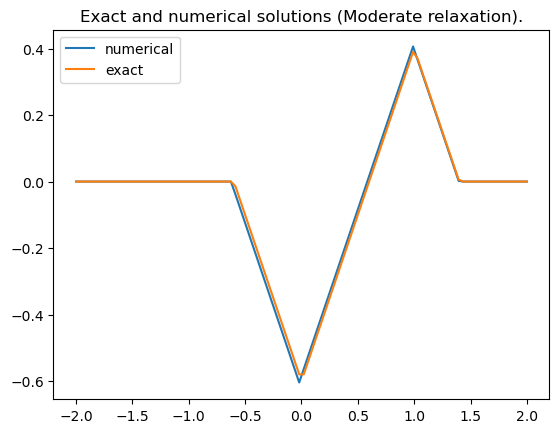

In [38]:
plt.title("Exact and numerical solutions (Moderate relaxation).")
comp_φ(1,0.8,Xs,1)

Primal-dual solver completed 111 steps in 0.0028619766235351562 seconds


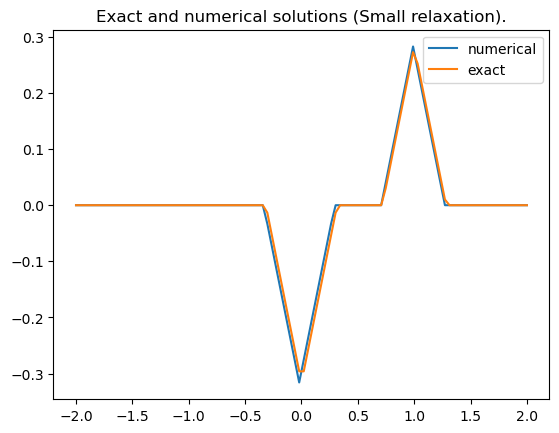

In [39]:
plt.title("Exact and numerical solutions (Small relaxation).")
comp_φ(1,0.8,Xs,0.1)

Primal-dual solver completed 531 steps in 0.011972188949584961 seconds


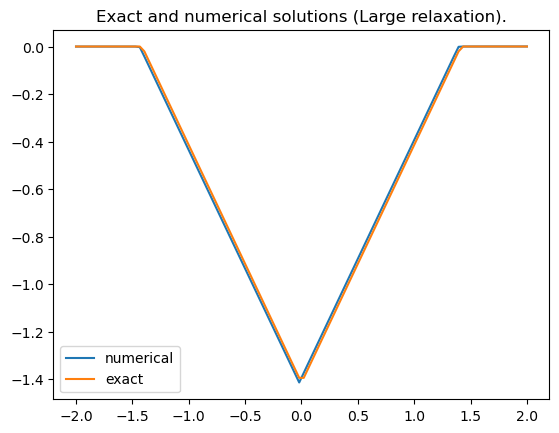

In [40]:
plt.title("Exact and numerical solutions (Large relaxation).")
comp_φ(1,0.8,Xs,10)

### 2.3 Vector data

The Beckman formulation of optimal transport, with a relaxed transport constraint, easily extends to vector data.

*On the lift mapping.*
One difficulty with oscillating data is that it tends to be transported on itself. In order to avoid this phenomenon, we add the norm $x_n = \sqrt{x_0^2+\cdots+x_{n-1}^2}$ of the signal as a supplementary channel. This can be regarded as a lift into the Lorentz cone
$$
    \{(x_0,\cdots,x_n)\in \bR^{n+1}|x_n\geq 0, x_n^2\geq x_0^2+\cdots+x_{n-1}^2\}
$$

In [41]:
def lift(μ0,μ1): return np.stack([μ0,μ1,np.sqrt(μ0**2+μ1**2)],axis=0)

In [42]:
# Generate the grid
Xs,Xv,dx = stag_grids(300,[-20,20])
Xs=Xs[0]; Xv=Xv[0]

In [43]:
# Generate the measures
def gaussian(x,ρ): return np.exp(-x**2/(2*ρ**2)) / np.sqrt(2*np.pi*ρ)
def damped_oscillating(x,ρ): 
    g = gaussian(x,ρ)
    return lift(g*np.cos(x),g*np.sin(x))

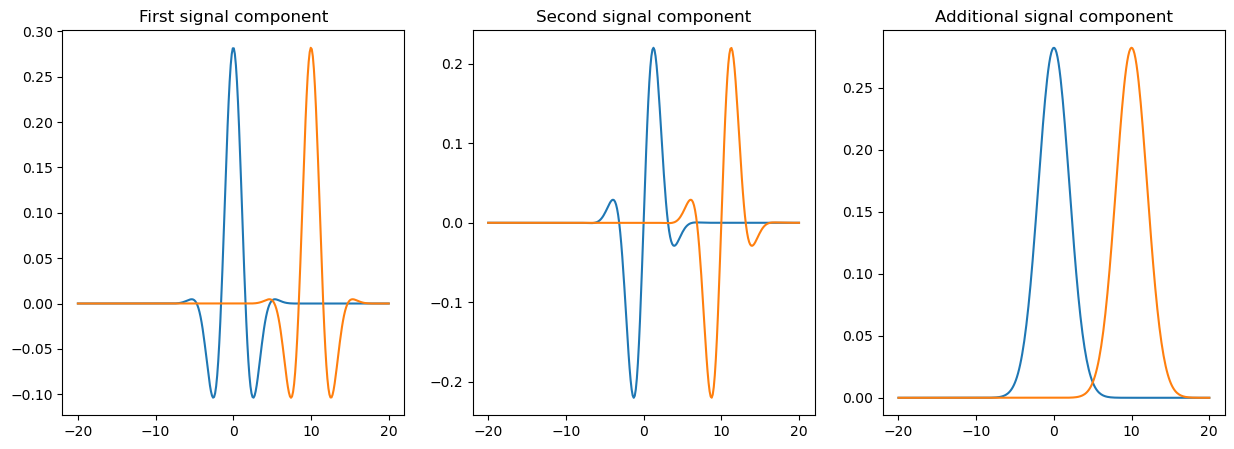

In [44]:
ρ = 2
x0 = 10
μ = damped_oscillating(Xs,ρ)
ν = damped_oscillating(Xs-x0,ρ)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("First signal component")
plt.plot(Xs,μ[0],Xs,ν[0])
plt.subplot(1,3,2)
plt.title("Second signal component")
plt.plot(Xs,μ[1],Xs,ν[1])
plt.subplot(1,3,3)
plt.title("Additional signal component")
plt.plot(Xs,μ[2],Xs,ν[2]);

In [45]:
def damped_oscillating_test(x0,ρ,x,channel=None,λ=None,mass_ratio=1.):
    μ = damped_oscillating(x,ρ)
    ν = mass_ratio*damped_oscillating(x-x0,ρ)
    ξ = μ-ν
    if channel is not None: ξ = ξ[channel]
    if λ is None: λ = 2*ρ/np.max(μ) # Somehow a length over an amplitude
    return λ,ξ

Let us compare the cpu and the gpu implementations on vector valued data.

<!---
#W1dist,(res,data,inputs) = damped_oscillating_test(x0,ρ,Xs,dx,channel=None)
#K = res['ops']['K']
#%%time
#for i in range(100):W1dist,(res,data,inputs) = damped_oscillating_test(x0,ρ,Xs,dx,channel=None,grad=K)
--->

<!---
%%time
x0=5; ρ = np.sqrt(3);


# Comparing with former implementation
def norm2(x,axis=None): 
    """Squared Euclidean norm, along given axis (optional)"""
    return np.sum(x**2,axis=axis)

def div(σ,dx):
    div_σ = np.concatenate((σ,np.zeros_like(σ[:1])),axis=0)
    div_σ[1:] -=σ
    div_σ /= dx
    return div_σ

def W1relax(σ,γ,dx,λ,ϵ=1e-3):
    """Discretizes \int |σ| + (λ/2) |div σ + γ|^2"""
    return np.sqrt(ϵ**2+σ**2).sum() + (λ/2) * norm2(div(σ,dx)+γ)


def div_v(σ,dx):
    div_σ = np.concatenate((σ,np.zeros_like(σ[:,:1])),axis=1)
    div_σ[:,1:] -=σ
    div_σ /= dx
    return div_σ

def W1relax_v(σ,γ,dx,λ,ϵ=1e-3):
    """Discretizes \int |σ| + (λ/2) |div σ + γ|^2"""
    vdim,n = γ.shape; σ = σ.reshape((vdim,n-1))
    return np.sqrt(ϵ**2+norm2(σ,axis=0)).sum() + (λ/2) * norm2(div_v(σ,dx)+γ)


W1dist,(res,data,inputs) = damped_oscillating_test(x0,ρ,Xs,dx,channel=0)
W1old = W1relax(res['y'][0],inputs['ξ'],dx,inputs['λ'],0)
print(f"Scalar case : {W1dist=}, {W1old=}")

W1dist,(res,data,inputs) = damped_oscillating_test(x0,ρ,Xs,dx,channel=None)
W1old = W1relax_v(res['y'],inputs['ξ'],dx,inputs['λ'],0)
print(f"Vector case : {W1dist=}, {W1old=}")
--->

In [46]:
x0=5; ρ = np.sqrt(3);
λ,ξ = damped_oscillating_test(x0,ρ,Xs)
compare_cpu_gpu((λ,ξ,dx))

In [47]:
x0s = np.sort(np.concatenate([np.linspace(-15,15,11),np.linspace(-4,4,10)]))

In [48]:
%%time
ρ=np.sqrt(3); mass_ratio=0.8
results = [[-solve1_ot(*damped_oscillating_test(x0,ρ,Xs,channel,mass_ratio=mass_ratio),dx,verbosity=0)[0]['dual_values'][-1]
            for x0 in x0s] for channel in [0,1,2,None]]

CPU times: user 405 ms, sys: 5.49 ms, total: 411 ms
Wall time: 411 ms


We empirically observe, for these parameters, that:
- Using an oscillating channel produces a sharp minimum, when the signals are in phase, but also some spurious local optima.
- Using the additional norm channel avoids the local minima problem, but the minimum is not all well localized.
- Using all channels combines the strengths of the other two approaches.

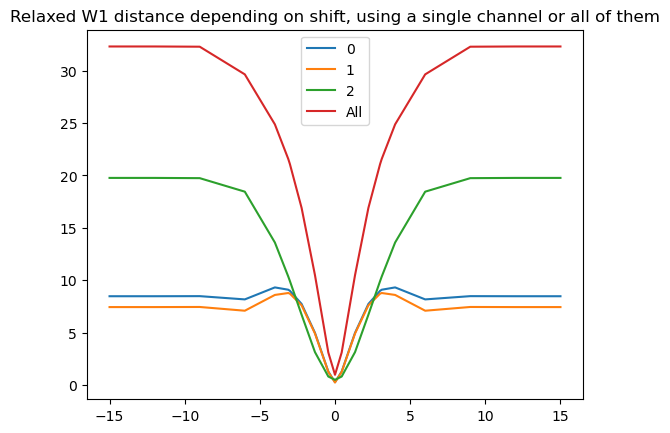

In [49]:
plt.plot(x0s,np.transpose(results));
plt.title("Relaxed W1 distance depending on shift, using a single channel or all of them")
plt.legend([0,1,2,"All"]);

## 3. Two dimensions

We illustrate some two dimensional test cases.

### 3.1 From a Dirac mass to another


In [50]:
n=100
Xs,Xv,dx = stag_grids((n,n+1),[[-1,-1],[1,1]])
μ = np.zeros(Xs[0].shape); ν = μ.copy() 
μ[n//6,n//3]=1/np.prod(dx); ν[3*n//4,5*n//6]=0.8/np.prod(dx)

ξ = ν-μ; λ = 1

In this quite singular problem instance, both the implicit and the explicit formulations need a very large number of iterations to reach convergence.

In [51]:
%%time
res1,_ = solve1_ot(λ,ξ,dx,maxiter=30000) 

Primal-dual solver completed 30000 steps in 4.870203971862793 seconds
CPU times: user 4.82 s, sys: 50.4 ms, total: 4.87 s
Wall time: 4.87 s


In [52]:
%%time
res2,_ = solve2_ot(λ,ξ,dx)

Primal-dual solver completed 5000 steps in 11.317248106002808 seconds
CPU times: user 11.5 s, sys: 167 ms, total: 11.7 s
Wall time: 11.6 s


In [53]:
print(f"Implicit : {res2['dual_values'][-1]} <= W1 dist <= {res2['primal_values'][-1]}")
print(f"Explicit : {-res1['primal_values'][-1]} <= W1 dist <= {-res1['dual_values'][-1]}")

Implicit : 2973.9283624321574 <= W1 dist <= 3067.16517585262
Explicit : 2901.201052824469 <= W1 dist <= 3067.4317100245635


The optimal flow is mostly, but not exactly (even in theory), concentrated on a line between the two Dirac masses.

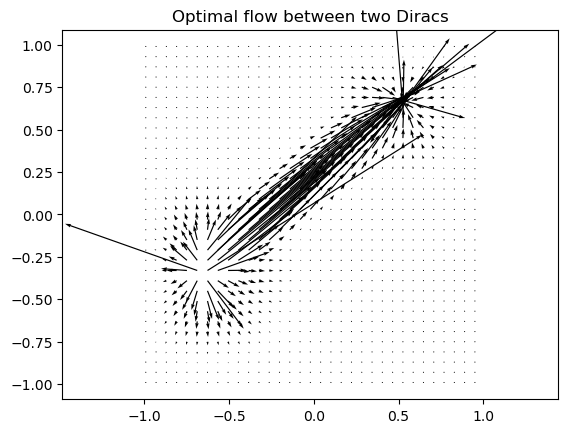

In [54]:
# Numerical results from the two methods are similar
# σ = res1['y'] 
σ = res2['x']

plt.title("Optimal flow between two Diracs")
Plotting.quiver(*Xv,*σ,subsampling=(3,3))
plt.axis('equal');

The optimal potential is reminiscent of the optimal one dimensional solution presented above, and seems to involve "distorted" hat functions, but admits no closed form expression to our knowledge.

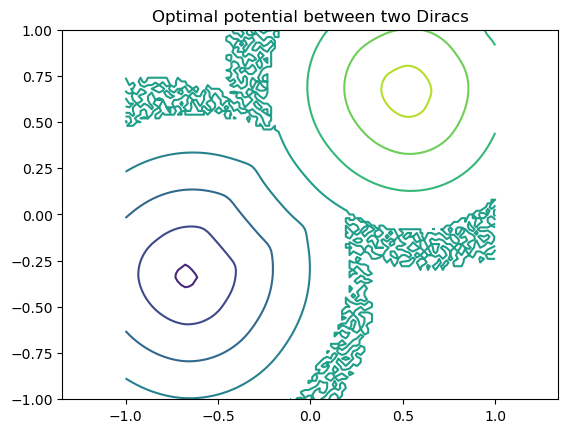

In [55]:
# Numerical results from the two methods are similar
#ϕ = res1['x']
ϕ = λ*(div2(res2['x'],dx)+ξ)

plt.title("Optimal potential between two Diracs")
plt.contour(*Xs,ϕ)
plt.axis('equal');

### 3.2 Oscillating signals and lift

In [56]:
# Generate the measures
def gaussian_2(x,ρ): 
    return np.exp(-np.sum(x**2,axis=0)/(2*ρ**2)) / np.sqrt(2*np.pi*ρ)**2

def damped_oscillating_2(x,v,ρ): 
    g = gaussian_2(x,ρ)
    ϕ = x[0]*v[0]+x[1]*v[1]
    return lift(g*np.cos(ϕ),g*np.sin(ϕ))

def damped_oscillating_test_2(x,v,ρ,x0,channel=None,mass_ratio=1):
    μ = damped_oscillating_2(x,v,ρ)
    ν = mass_ratio*damped_oscillating_2(x-fd.as_field(x0,x.shape[1:]),v,ρ)
    ξ = μ-ν    
    λ = 2*ρ/np.max(μ) # Somehow a length over an amplitude
    if channel is not None: ξ = ξ[channel]
    if λ is None: λ = 2*ρ/np.max(μ) # Somehow a length over an amplitude
    return λ,ξ

In [57]:
Xs,Xv,dx = stag_grids((100,100),[[-1,-1],[1,1]])

We consider two-channel oscillating signals in two dimensions. The lifting procedure adds a third channel, defined as the norm $\mu_2 = \sqrt{\mu_0^2+\mu_1^2}$ of the first two.

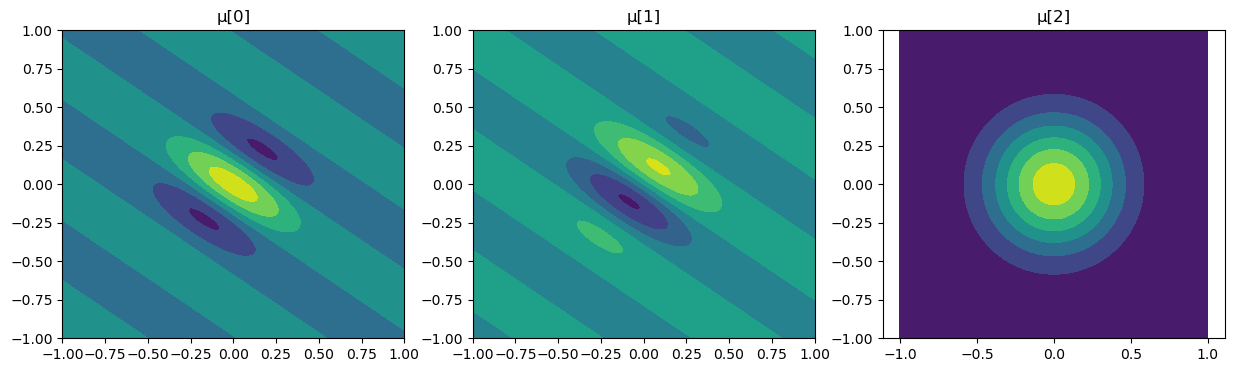

In [58]:
μ = damped_oscillating_2(Xs,[6,8],0.3)

figs,axs = plt.subplots(1,3,figsize=[15,4])
for i,ax in enumerate(axs):
    ax.contourf(*Xs,μ[i])
    ax.set_title(f"μ[{i}]")
    plt.axis('equal')

The two numerical solvers, and the GPU implementation, solve this problem without issues.

In [59]:
λ,ξ = damped_oscillating_test_2(Xs,[6,8],0.3,[0.2,0.4],channel=None)

In [60]:
%%time
res1,_ = solve1_ot(λ,ξ,dx)

Primal-dual solver completed 551 steps in 0.2427656650543213 seconds
CPU times: user 234 ms, sys: 12 ms, total: 246 ms
Wall time: 247 ms


In [61]:
%%time
res2,_ = solve2_ot(λ,ξ,dx)

Primal-dual solver completed 71 steps in 0.5268058776855469 seconds
CPU times: user 1.23 s, sys: 514 ms, total: 1.74 s
Wall time: 1.42 s


In [62]:
%%time
if xp is not np: res3,_ = solve3_ot(λ,ξ,dx)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.67 µs


In [63]:
dv = np.prod(dx)
print(f"Implicit, niter={res2['niter']}: {dv*res2['dual_values'][-1]} <= W1 dist <= {dv*res2['primal_values'][-1]}")
print(f"Explicit niter={res1['niter']}: {-dv*res1['primal_values'][-1]} <= W1 dist <= {-dv*res1['dual_values'][-1]}")
if xp is not np: print(f"Explicit (gpu), niter={res3['niter']}: {-dv*res3['primal_values'][-1]} <= W1 dist <= {-dv*res3['dual_values'][-1]}")

Implicit, niter=71: 0.0721057125177082 <= W1 dist <= 0.07217754932205549
Explicit niter=551: 0.07210719794400629 <= W1 dist <= 0.07217754592386884


The first (as well as the second) channel of the measures is very oscillatory, which leads to the issue of mass transported on itself. 
The last channel (the norm of the first two, i.e. the signal envelope) is a smooth bump, which leads to poor sensitivity w.r.t. translations.

Primal-dual solver completed 241 steps in 0.03827500343322754 seconds


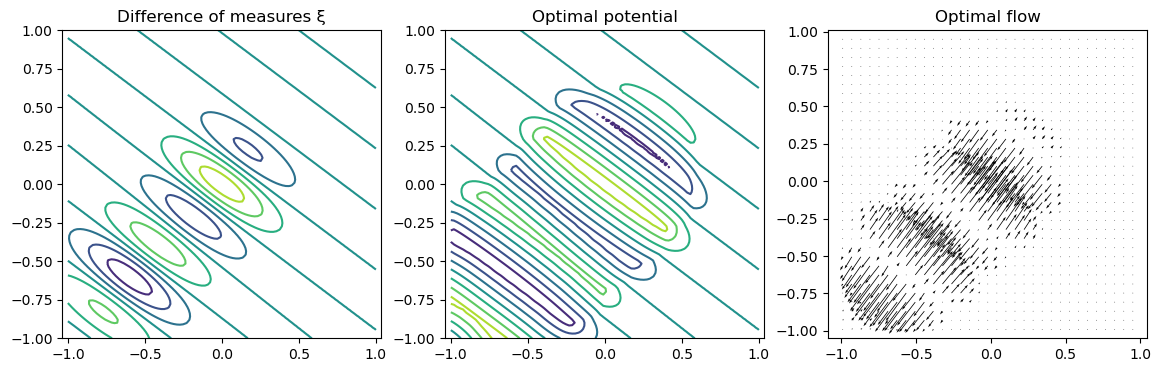

In [64]:
λ,ξ = damped_oscillating_test_2(Xs,[6,8],0.3,[-0.6,-0.6],channel=0)
res1,_ = solve1_ot(λ,ξ,dx)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1); plt.title("Difference of measures ξ")
plt.contour(*Xs,ξ); plt.axis('equal');
plt.subplot(1,3,2); plt.title("Optimal potential")
plt.contour(*Xs,res1['x']); plt.axis('equal');
plt.subplot(1,3,3); plt.title("Optimal flow")
Plotting.quiver(*Xv,*res1['y'],subsampling=(3,3)); plt.axis('equal');

Primal-dual solver completed 711 steps in 0.11305522918701172 seconds


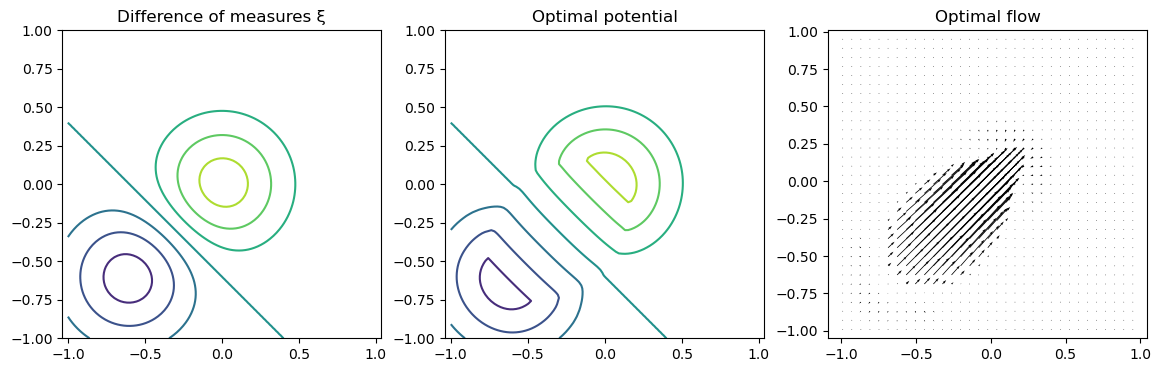

In [65]:
λ,ξ = damped_oscillating_test_2(Xs,[6,8],0.3,[-0.6,-0.6],channel=2)
res1,_ = solve1_ot(λ,ξ,dx)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1); plt.title("Difference of measures ξ")
plt.contour(*Xs,ξ); plt.axis('equal');
plt.subplot(1,3,2); plt.title("Optimal potential")
plt.contour(*Xs,res1['x']); plt.axis('equal');
plt.subplot(1,3,3); plt.title("Optimal flow")
Plotting.quiver(*Xv,*res1['y'],subsampling=(3,3)); plt.axis('equal');

Similarly to the one dimensional case : 
- Using only an oscillating channel (0 or 1) yields several local minima and maxima.
- Using only channel 2, which is positive, yields a single well, but behavior near the minimum is very smooth. 
- Using all channels together yields a single well, with a minimizer that is well localized.

Note that in the latter case, we have more resolution in the direction orthogonal to the phase. 

In [66]:
%%time 
# Note : this cell is a bit long to execute, especially on the CPU
if xp is np: solve_ot,nshift = solve1_ot,7
else: solve_ot,nshift = solve3_ot,9 # Use gpu if available
shift = np.linspace(-0.6,0.6,nshift)
shifts = np.array(np.meshgrid(shift,shift,indexing='ij'))
results = [[[-solve_ot(*damped_oscillating_test_2(Xs,[6,8],0.3,shifts[:,i,j],channel),dx,verbosity=0)[0]['dual_values'][-1]
             for j in range(nshift)] for i in range(nshift)] 
           for channel in (0,1,2,None)]

CPU times: user 23.1 s, sys: 678 ms, total: 23.7 s
Wall time: 23.7 s


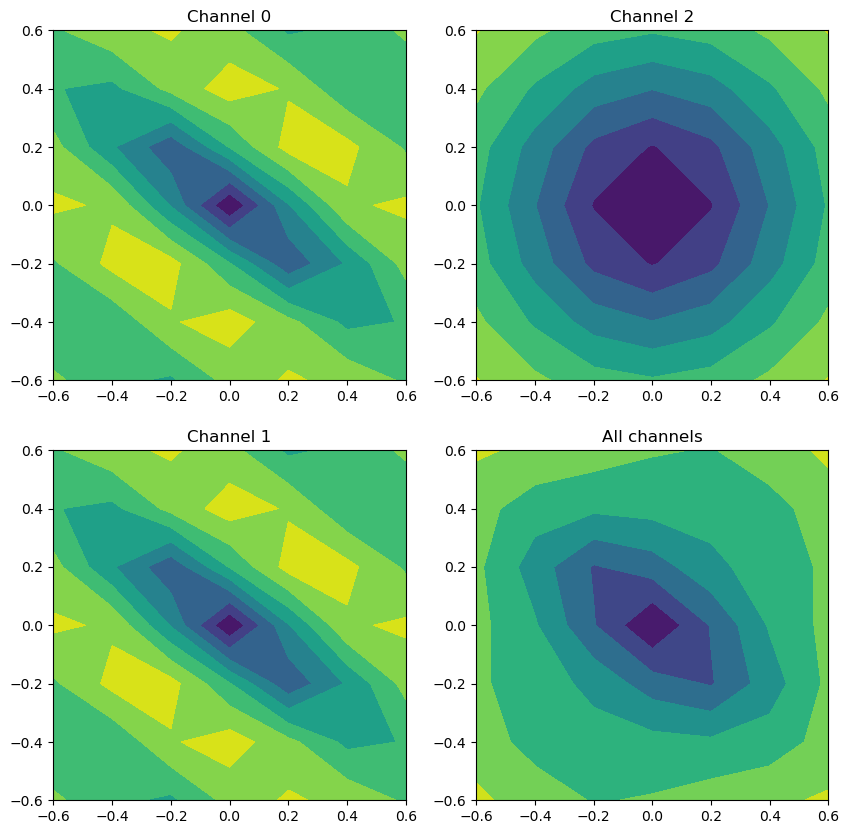

In [67]:
fig,axs = plt.subplots(2,2,figsize=[10,10])
axs[0,0].contourf(*shifts,results[0]); axs[0,0].set_title("Channel 0")
axs[1,0].contourf(*shifts,results[1]); axs[1,0].set_title("Channel 1")
axs[0,1].contourf(*shifts,results[2]); axs[0,1].set_title("Channel 2")
axs[1,1].contourf(*shifts,results[3]); axs[1,1].set_title("All channels");

### 3.3 A loss function between seismograms

One of the objective of this notebook is to investigate loss functions between multichannel seismograms.
We subsample this large test case in order to have reasonnable runtimes, and observe that : 
- The implicit scheme converges in approximately 200 steps, independently of the subsampling rate. However, its efficiency is limited by the choice of linear solver
- The explicit scheme (cpu or gpu) needs excessively many steps to reach convergence, at least 100000/k where k is the subsampling rate. This makes it prohibitive for our usage. 

<!---
μ1 = np.fromfile("data/mu1_0064",dtype=np.float32).reshape(3000,169)
μ2 = np.fromfile("data/mu2_0064",dtype=np.float32).reshape(3000,169)
ν1 = np.fromfile("data/nu1_0064",dtype=np.float32).reshape(3000,169)
ν2 = np.fromfile("data/nu2_0064",dtype=np.float32).reshape(3000,169)
ξ = np.array([ν1-μ1,ν2-μ2])

np.savez_compressed("data/xi.npz",xi0=ξ[0],xi1=ξ[1])
--->

In [68]:
subsampling=4 

In [69]:
data = Plotting.open_local_or_web(np.load,"Notebooks_Div/TestData/xi.npz")
ξ = lift(data['xi0'],data['xi1'])
λ = 21

ξ = ξ[:,::subsampling,::subsampling] # subsample (optional, but computation time is long otherwise)
Xs,Xv,dx = stag_grids(ξ.shape[1:],[[0,0],[1,1]])

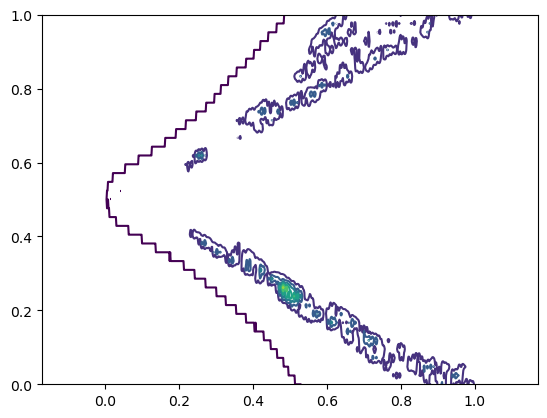

In [70]:
plt.contour(*Xs,ξ[2])
plt.axis('equal');

In [71]:
res1,_ = solve1_ot(λ,ξ,dx)

Primal-dual solver completed 5000 steps in 10.031741857528687 seconds


In [72]:
%%time
res2,_ = solve2_ot(λ,ξ,dx)

Primal-dual solver completed 121 steps in 2.857008934020996 seconds
CPU times: user 3.95 s, sys: 167 ms, total: 4.12 s
Wall time: 4.12 s


In [73]:
if xp is not np: res3,_ = solve3_ot(λ,ξ,dx,maxiter=100000,rtol=0) 

- The implicit scheme converged correctly.
- The explicit scheme (cpu) did not have a sufficient iteration budget, and produces incorrect energies. 
- The explicit scheme (gpu) is limited by the float32 accuracy. Even with a very large iteration budget, it does not reduce the primal dual gap to acceptable levels. (Note : the keyword argument `rtol=0` removes a stopping criterion based on the stabilization of the solution, so that only the primal-dual gap is considered.)

In [74]:
dv=np.prod(dx)
print(f"Implicit, niter={res2['niter']}: {dv*res2['dual_values'][-1]} <= W1 dist <= {dv*res2['primal_values'][-1]}")
print(f"Explicit niter={res1['niter']}: {-dv*res1['primal_values'][-1]} <= W1 dist <= {-dv*res1['dual_values'][-1]}")
if xp is not np: print(f"Explicit (gpu), niter={res3['niter']}: {-dv*res3['primal_values'][-1]} <= W1 dist <= {-dv*res3['dual_values'][-1]}")

Implicit, niter=121: 8.432089857537884 <= W1 dist <= 8.43861283497407
Explicit niter=5000: -106.24535782242252 <= W1 dist <= 8.439386190965097


The primal dual gap of the explicit scheme on the gpu does not decrease to zero due to fp32 limited accuracy.

In [75]:
if xp is not np: 
    plt.title("Primal-dual gap, explicit scheme (gpu)") 
    plt.loglog(res3['primal_values']-res3['dual_values']);